# 4.1 Training and testing

In this step we create our kNN model based on the data we extracted in 3.1 (manual feature selection)

### 1. Adding the libraries we need

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

### 2. Read in the feature dataset from the result of 3.1 notebook

In [2]:
directory = "../dataset-numpy/"

dataset = pd.read_csv(os.path.join(directory, '3.1 - features.csv'), delimiter=',', header=0)

dataset.describe(include='all')

,label,area,axis_major_length,axis_minor_length,eccentricity,h_sym_err_percent,v_sym_err_percent
count,1446,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
unique,12,NaN,NaN,NaN,NaN,NaN,NaN
top,ash,NaN,NaN,NaN,NaN,NaN,NaN
freq,162,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5940.992393,143.654948,103.994480,0.651062,0.309205,0.351002
std,NaN,1285.099755,16.419462,14.134005,0.146175,0.081994,0.128166
min,NaN,1469.000000,110.482240,14.198591,0.105603,0.052680,0.030307
25%,NaN,4995.250000,132.102996,94.669247,0.564980,0.256113,0.254683
50%,NaN,5950.500000,141.979676,102.965786,0.673206,0.311785,0.358025
75%,NaN,6802.500000,153.354823,114.501330,0.755008,0.362350,0.451873


### 3. Create training and testing datasets

We will use the `train_test_split` function from `sklearn` to split the dataset into training and testing datasets. We will use 75% of the data for training and 25% for testing.

In [3]:
X = dataset.loc[:, dataset.columns != 'label'] # Features
y = dataset.loc[:, dataset.columns == 'label'] # Target

rnd_state = 42 # Random state for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=rnd_state)

### 4. Scale the data

For kNN, we want to make sure that all data points are on the same scale, so no value is dominating. We will use the `MinMaxScaler` function from `sklearn` to scale the data. We scale the data in this step, as the scaler works best on data that is split into X and y (which is part of the training and testing process).

In [4]:
# load in the scaler
scaler_path = os.path.join("../classifiers/", '3.1 - scaler.pkl')
with open(scaler_path, 'rb') as file:
    scaler = pickle.load(file)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 5. Find the best hyperparameters

kNN has a lot of hyperparameters that we can tune. We will use the `GridSearchCV` function from `sklearn` to find the best hyperparameters for our model. We will use 5-fold cross validation to find the best hyperparameters.

In [5]:
parameters = {
    'n_neighbors':range(1, 20),
    'weights':['uniform', 'distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':range(1, 10),
    'p':[1,2]
}

testing_knn = KNeighborsClassifier()

clf = GridSearchCV(testing_knn, parameters, cv=5, scoring='accuracy')

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}


### 6. Creating and fitting model

We create and train the kNN model with our training dataset using the best hyperparameters we found in the previous step.

In [6]:
knn = KNeighborsClassifier(**clf.best_params_)

accuracy_scores = cross_val_score(knn, X_train, y_train, cv=5)

knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(leaf_size=1, n_neighbors=12, p=1, weights='distance')

### 7. Making predictions

Now we can make prediction. We attempt to predict each of our testing dataset and see how well our model performs. We print out the accuracy score and the confusion matrix to see how well our model performs and what runes get confused with each other.

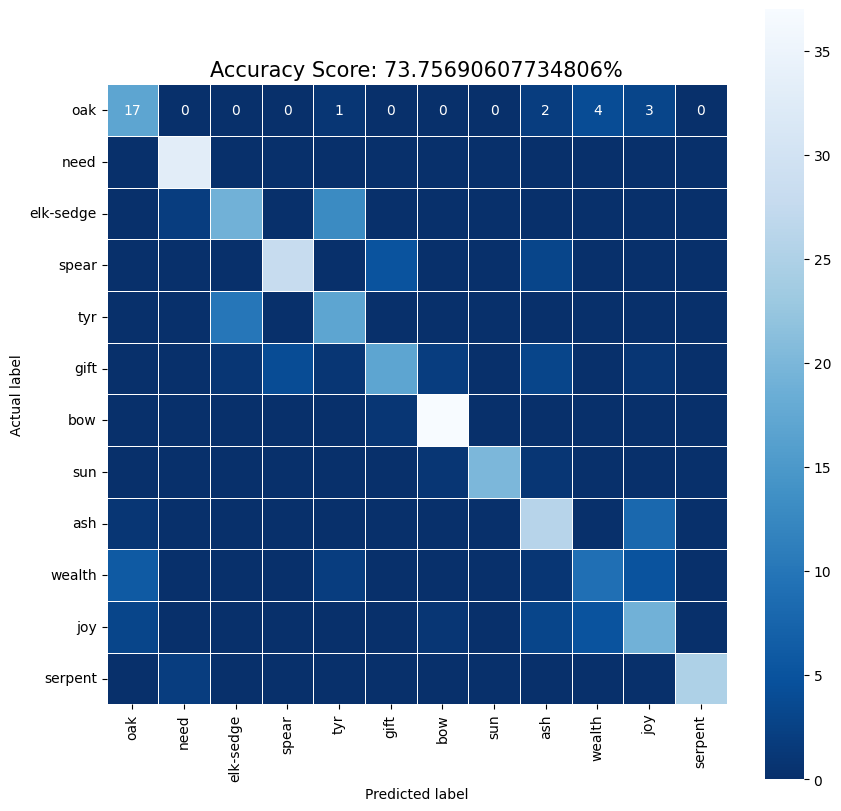

In [7]:
y_pred = knn.predict(X_test)

labels = ['oak', 'need', 'elk-sedge', 'spear', 'tyr', 'gift', 'bow', 'sun', 'ash', 'wealth', 'joy', 'serpent'] # used to make sure the confusion matrix is in the correct order

cm = confusion_matrix(y_test, y_pred, labels=labels)

score = accuracy_score(y_test, y_pred)*100

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}%'.format(score), size=15)
plt.show()


As we can see from the above confusion matrix, our model got some confusion. The model confused `tyr`, `elk-sedge`, `spear`, `ash`, `joy`, and `wealth` the most often. This is likely because we only selected 6 features in total.

Now, let's see if our model is overfitting. We take the scores from using kfold on our model and checking for extreme differences between the individual accuracy scores and the standard deviation of the accuracy scores.

In [8]:
# Print the individual scores to see if there are extreme differences
for fold, score in enumerate(accuracy_scores):
    print(f"Fold {fold + 1} - Accuracy score: {score}")
print()

# Print the difference between the smallest and largest score
score_difference = max(accuracy_scores) - min(accuracy_scores)
print(f"Maximum difference between accuracy scores {score_difference:.2f}")

# Print the standard deviation to check the variability of the model
deviation = np.std(accuracy_scores)
print(f"Standard Deviation of accuracy scores: {deviation:.2f}")

Fold 1 - Accuracy score: 0.7188940092165899
Fold 2 - Accuracy score: 0.6820276497695853
Fold 3 - Accuracy score: 0.7188940092165899
Fold 4 - Accuracy score: 0.728110599078341
Fold 5 - Accuracy score: 0.7546296296296297

Maximum difference between accuracy scores 0.07
Standard Deviation of accuracy scores: 0.02


The maximum difference between accuracy scores is 7% with a standard deviation of 2%, meaning that there likely is some overfitting.

### 8. Save the model

We binary serialize the model and save it to a file so we can use it later in our web app.

In [9]:
directory = "../classifiers/" 
path = os.path.join(directory, '4.1 - knn model.pkl')

with open(path, 'wb') as file:
    pickle.dump(knn, file)